<a href="https://colab.research.google.com/github/victorialovefranklin/Toward-Climate-Resilient-Energy-Systems/blob/main/EAGLEI_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[OK] Loaded 409,920 rows across 10 files (2014–2023).

=== AI Summary ===
Records: 409,920 • Columns: 9 • Years: 2014–2023
Types: float64×4, object×4, int64×1
Avg missingness: 22.6% • Numeric: 5 • Categorical: 4
Notes: customers_out: highly right-skewed (skew=18.97); sum: highly right-skewed (skew=25.27)

=== Snapshot Tables ===


,column,dtype
fips_code,fips_code,float64
county,county,object
state,state,object
customers_out,customers_out,float64
run_start_time,run_start_time,object
year,year,int64
__source_file,__source_file,object
eaglei_outages_2018,eaglei_outages_2018,float64
sum,sum,float64


,column,missing_%
eaglei_outages_2018,eaglei_outages_2018,95.63
sum,sum,81.82
customers_out,customers_out,22.00
fips_code,fips_code,4.37
county,county,0.00
run_start_time,run_start_time,0.00
state,state,0.00
__source_file,__source_file,0.00
year,year,0.00


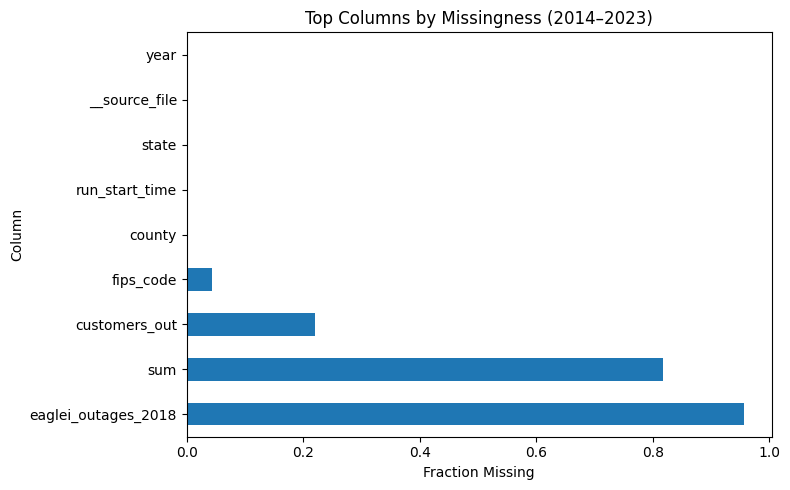


=== Numeric Distributions ===


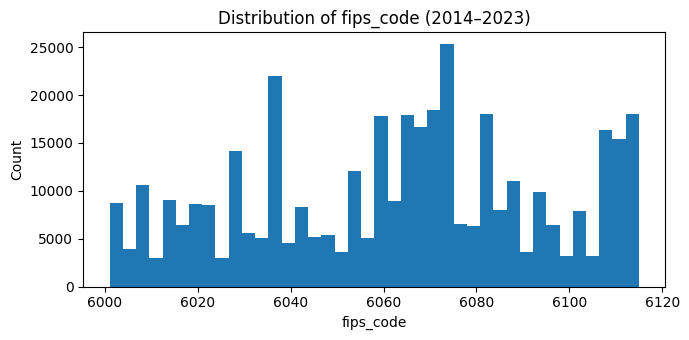

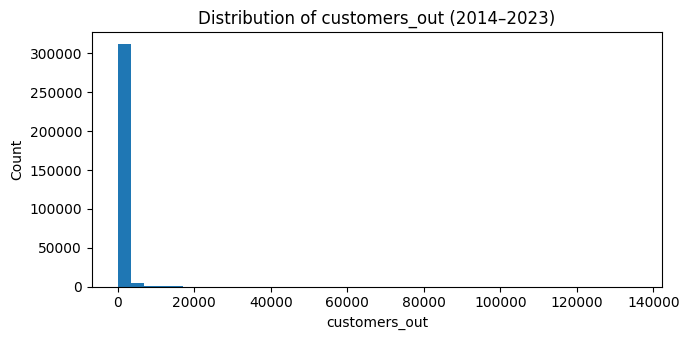

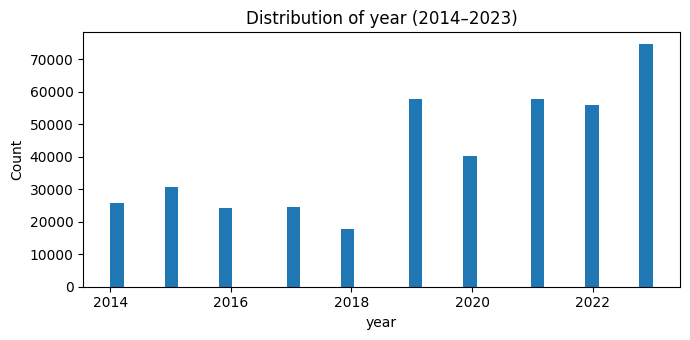

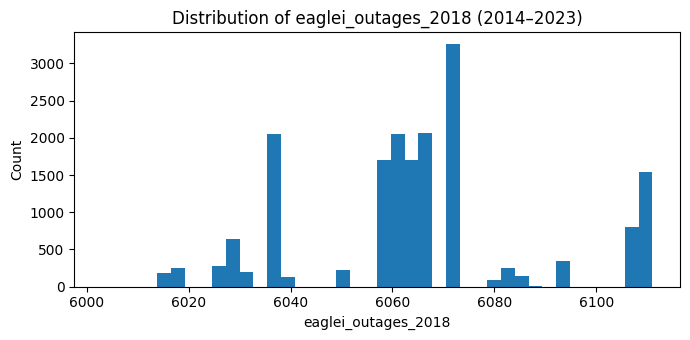

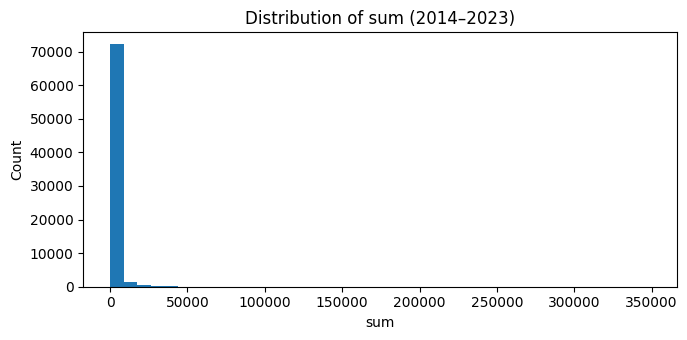


=== Top Categorical Levels (preview) ===


,column,value,count
0,county,Los Angeles,24061
1,county,San Diego,21119
2,county,San Bernardino,19777
3,county,Riverside,19626
4,county,Orange,19523
5,county,Ventura,16812
6,county,Sacramento,16436
7,county,Yolo,13425
8,county,Kern,13174
9,county,Tulare,13052



=== Top Counties by Outage Impact ===


,fips_code,county,total_customers_out
18,6037.0,Los Angeles,32094152.0
55,6111.0,Ventura,10905070.0
35,6071.0,San Bernardino,10560749.0
36,6073.0,San Diego,8970219.0
29,6059.0,Orange,8800440.0
28,6057.0,Nevada,8384208.0
32,6065.0,Riverside,6762265.0
33,6067.0,Sacramento,6433107.0
8,6017.0,El Dorado,4310417.0
43,6087.0,Santa Cruz,3962331.0


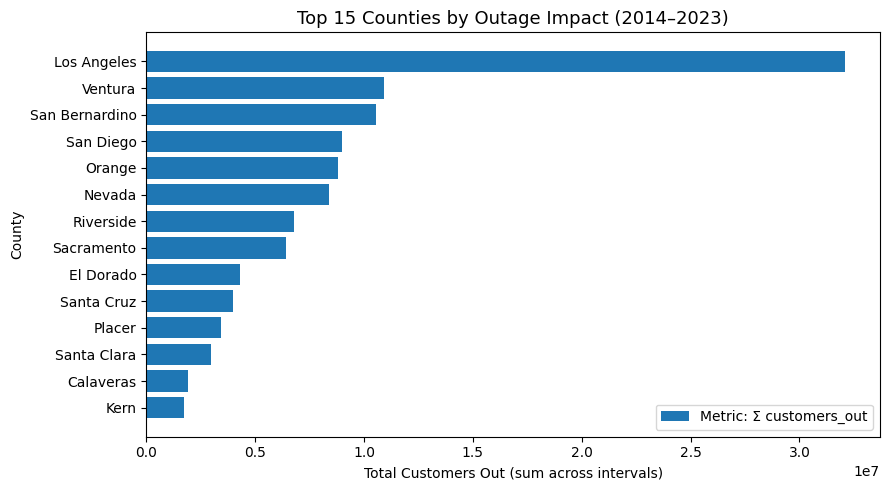

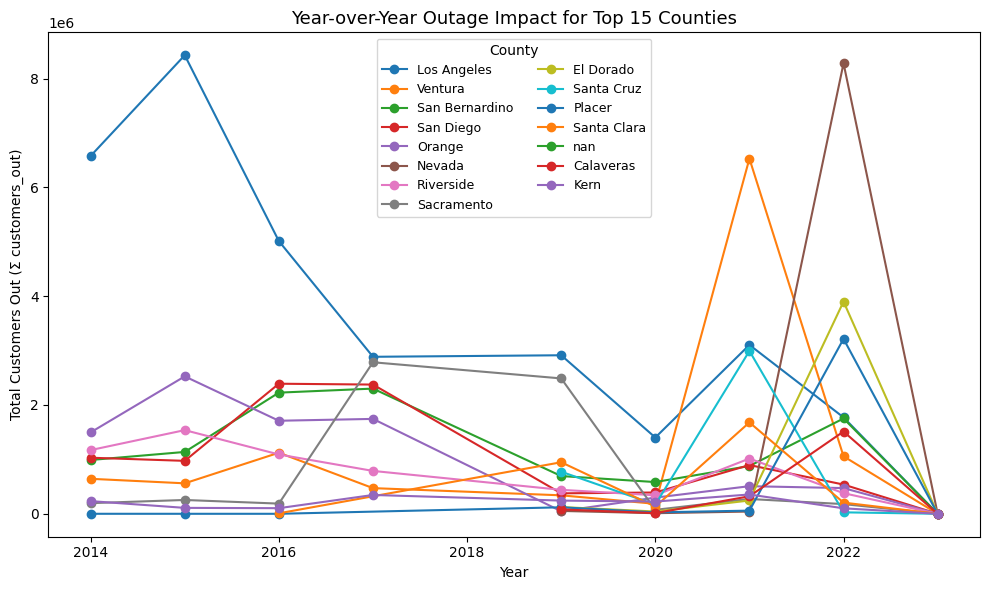


=== Yearly Totals & YoY Change (2014–2023) ===


,year,metric_total,percentage_change
0,2014,13058751.0,NaN
1,2015,16236650.0,24.3
2,2016,14539718.0,-10.5
3,2017,14628709.0,0.6
4,2018,6366497.0,-56.5
5,2019,16056543.0,152.2
6,2020,5554922.0,-65.4
7,2021,28119087.0,406.2
8,2022,28980352.0,3.1
9,2023,0.0,-100.0


Highest: 2022 (28,980,352) • Lowest: 2023 (0)


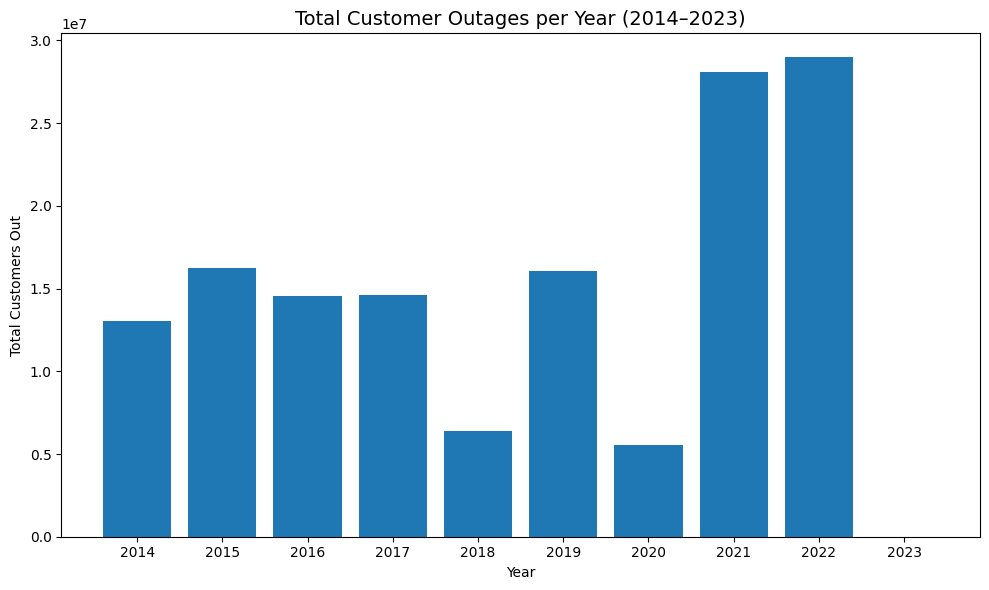


=== Done. All results rendered directly in the notebook. ===


In [36]:
# ==============================
# EAGLE-I (2014–2023) — Colab Notebook Runner (No HTML export)
# ==============================

# -------- CONFIG --------
YEAR_RANGE = range(2014, 2024)        # inclusive 2014–2023
FILE_TEMPLATE = "/content/eaglei_outages_{year}.csv"
TOP_N_COUNTIES = 15
MAX_PLOTS_PER_SECTION = 12
POINT_SAMPLE_FOR_MAP = 50_000
SEED = 42

# Optionally hard-set if auto-detect isn't right:
FIPS_COL = None           # e.g., "county_fips", "fips_code", "GEOID"
CUSTOMERS_COL = None      # e.g., "customers_out"

# -------- Quiet installs (safe to rerun in Colab) --------
import sys, subprocess, warnings, os
warnings.filterwarnings("ignore")

def _pip(pkg):
    try:
        __import__(pkg.split("==")[0].replace("-", "_"))
    except Exception:
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", pkg], check=False)

for p in ["pandas", "numpy", "matplotlib", "geopandas", "shapely", "pyproj", "mapclassify", "folium"]:
    _pip(p)

# -------- Imports --------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Geospatial
gpd_ok, folium_ok = True, True
try:
    import geopandas as gpd
    from shapely.geometry import Point
except Exception as e:
    gpd_ok = False
    print(f"[WARN] GeoPandas not available: {e}")
try:
    import folium
except Exception as e:
    folium_ok = False
    print(f"[WARN] Folium not available: {e}")

# -------- Load all years --------
frames, missing_files = [], []
for yr in YEAR_RANGE:
    fp = FILE_TEMPLATE.format(year=yr)
    if os.path.exists(fp):
        try:
            df_i = pd.read_csv(fp)
            if "year" not in df_i.columns:
                df_i["year"] = yr
            else:
                df_i["year"] = pd.to_numeric(df_i["year"], errors="coerce").fillna(yr).astype(int)
            df_i["__source_file"] = os.path.basename(fp)
            frames.append(df_i)
        except Exception as e:
            print(f"[WARN] Could not load {fp}: {e}")
    else:
        missing_files.append(fp)

if missing_files:
    print("[WARN] Missing files skipped:")
    for m in missing_files:
        print("  -", m)

if not frames:
    raise RuntimeError("No CSVs loaded. Check file paths or names.")

df = pd.concat(frames, ignore_index=True)
df = df[(df["year"] >= 2014) & (df["year"] <= 2023)].copy()
df.drop_duplicates(inplace=True)
print(f"[OK] Loaded {len(df):,} rows across {len(frames)} files (2014–2023).")

# -------- Column detection --------
def first_existing(frame, candidates):
    return next((c for c in candidates if c in frame.columns), None)

customers_candidates = ["customers_out", "customers", "cust_out", "customers_outage", "outage_customers"]
fips_candidates = ["county_fips", "fips", "fips_code", "county_fips_code", "GEOID"]
county_name_candidates = ["county", "county_name"]
lat_candidates = ["lat", "latitude", "y", "Lat", "Latitude"]
lon_candidates = ["lon", "longitude", "x", "Lon", "Longitude", "long"]

CUSTOMERS_COL = CUSTOMERS_COL or first_existing(df, customers_candidates)
FIPS_COL      = FIPS_COL or first_existing(df, fips_candidates)
COUNTY_NAME_COL = first_existing(df, county_name_candidates)
LAT_COL, LON_COL = first_existing(df, lat_candidates), first_existing(df, lon_candidates)

# -------- AI-style summaries --------
def pct(x):
    try: return f"{100*float(x):.1f}%"
    except: return "0.0%"

def ai_summary(df_):
    nrows, ncols = df_.shape
    miss_rate = df_.isna().mean().mean()
    dtypes = df_.dtypes.astype(str).value_counts().to_dict()
    num_cols = df_.select_dtypes(include=np.number).columns.tolist()
    cat_cols = df_.select_dtypes(exclude=np.number).columns.tolist()
    span = f"{int(df_['year'].min())}–{int(df_['year'].max())}"
    return (
        f"Records: {nrows:,} • Columns: {ncols} • Years: {span}\n"
        f"Types: {', '.join([f'{k}×{v}' for k,v in dtypes.items()])}\n"
        f"Avg missingness: {pct(miss_rate)} • Numeric: {len(num_cols)} • Categorical: {len(cat_cols)}"
    )

def ai_notes(df_):
    notes = []
    for c in df_.select_dtypes(include=np.number).columns[:8]:
        s = df_[c].dropna()
        if len(s) < 30: continue
        try:
            sk = float(s.skew())
            if abs(sk) > 1:
                notes.append(f"{c}: highly {'right' if sk>0 else 'left'}-skewed (skew={sk:.2f})")
        except: pass
    num = df_.select_dtypes(include=np.number).columns.tolist()
    if len(num) >= 2:
        corr = df_[num].corr(numeric_only=True)
        tri = corr.where(~np.eye(corr.shape[0], dtype=bool)).unstack().dropna()
        strong = tri[tri.abs() > 0.7].sort_values(key=np.abs, ascending=False)
        if not strong.empty:
            pairs = [f"{a}–{b} (r={strong[(a,b)]:.2f})" for (a,b) in strong.index[:6]]
            notes.append("Potential multicollinearity: " + ", ".join(pairs))
    return "Notes: " + ("; ".join(notes) if notes else "No severe multicollinearity detected.")

print("\n=== AI Summary ===")
print(ai_summary(df))
print(ai_notes(df))

# -------- Snapshot tables --------
print("\n=== Snapshot Tables ===")
dtype_tbl = pd.DataFrame({"column": df.columns, "dtype": df.dtypes.astype(str)})
miss_tbl  = pd.DataFrame({"column": df.columns, "missing_%": (df.isna().mean()*100).round(2)}).sort_values("missing_%", ascending=False)
display(dtype_tbl)
display(miss_tbl)

# -------- Missingness plot --------
try:
    miss = df.isna().mean().sort_values(ascending=False)
    if miss.sum() > 0:
        fig, ax = plt.subplots(figsize=(8,5))
        miss.head(20).plot(kind="barh", ax=ax)
        ax.set_title("Top Columns by Missingness (2014–2023)", fontsize=12)
        ax.set_xlabel("Fraction Missing"); ax.set_ylabel("Column")
        plt.tight_layout(); plt.show()
except Exception as e:
    print("[WARN] Missingness plot:", e)

# -------- Numeric distributions --------
print("\n=== Numeric Distributions ===")
num_cols = df.select_dtypes(include=np.number).columns.tolist()
for c in num_cols[:MAX_PLOTS_PER_SECTION]:
    try:
        vals = df[c].dropna().values
        if len(vals)==0: continue
        fig, ax = plt.subplots(figsize=(7,3.5))
        ax.hist(vals, bins=40)
        ax.set_title(f"Distribution of {c} (2014–2023)", fontsize=12)
        ax.set_xlabel(c); ax.set_ylabel("Count")
        plt.tight_layout(); plt.show()
    except: pass

# -------- Top categorical preview --------
print("\n=== Top Categorical Levels (preview) ===")
cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()
cat_preview = []
for c in cat_cols[:10]:
    try:
        vc = df[c].astype(str).value_counts().head(10)
        if len(vc):
            cat_preview.append(pd.DataFrame({"column": c, "value": vc.index, "count": vc.values}))
    except: pass
if cat_preview:
    display(pd.concat(cat_preview, ignore_index=True))

# -------- Correlation heatmap --------
# Removed correlation heatmap as requested by the user.

# -------- Top counties by outage impact --------
def best_customers_col(df_):
    for c in customers_candidates:
        if c in df_.columns: return c
    return None

CUSTOMERS_COL = CUSTOMERS_COL or best_customers_col(df)

print("\n=== Top Counties by Outage Impact ===")
if CUSTOMERS_COL and (FIPS_COL or COUNTY_NAME_COL):
    group_keys = [c for c in [FIPS_COL, COUNTY_NAME_COL] if c]
    grp = (df.groupby(group_keys, dropna=False)[CUSTOMERS_COL]
             .sum().reset_index()
             .sort_values(CUSTOMERS_COL, ascending=False))
    top_counties = grp.head(TOP_N_COUNTIES).copy()
    display(top_counties.rename(columns={CUSTOMERS_COL: "total_customers_out"}))

    # Bar chart
    try:
        fig, ax = plt.subplots(figsize=(9,5))
        label_col = COUNTY_NAME_COL or FIPS_COL
        ax.barh(top_counties[label_col].astype(str), top_counties[CUSTOMERS_COL].values)
        ax.invert_yaxis()
        ax.set_title(f"Top {TOP_N_COUNTIES} Counties by Outage Impact (2014–2023)", fontsize=13)
        ax.set_xlabel("Total Customers Out (sum across intervals)")
        ax.set_ylabel(label_col.replace("_"," ").title())
        ax.legend([f"Metric: Σ {CUSTOMERS_COL}"], loc="lower right", frameon=True)
        plt.tight_layout(); plt.show()
    except Exception as e:
        print("[WARN] Top counties plot:", e)

    # Year-over-year lines for top N (if year present)
    try:
        if "year" in df.columns:
            yoy = (df[df[group_keys[0]].isin(top_counties[group_keys[0]])]
                   .groupby(group_keys + ["year"], dropna=False)[CUSTOMERS_COL]
                   .sum().reset_index())
            fig, ax = plt.subplots(figsize=(10,6))
            for _, row in (top_counties[[group_keys[0]]].drop_duplicates()).iterrows():
                key_val = row[group_keys[0]]
                sub = yoy[yoy[group_keys[0]] == key_val]
                label = str(key_val)
                if COUNTY_NAME_COL and group_keys[0] == (FIPS_COL or ""):
                    n = grp[grp.get(FIPS_COL, pd.Series([])) == key_val].get(COUNTY_NAME_COL, pd.Series([])).dropna().astype(str)
                    if not n.empty: label = n.iloc[0]
                ax.plot(sub["year"], sub[CUSTOMERS_COL], marker="o", label=label)
            ax.set_title(f"Year-over-Year Outage Impact for Top {TOP_N_COUNTIES} Counties", fontsize=13)
            ax.set_xlabel("Year"); ax.set_ylabel(f"Total Customers Out (Σ {CUSTOMERS_COL})")
            ax.legend(title="County", fontsize=9, ncol=2)
            plt.tight_layout(); plt.show()
    except Exception as e:
        print("[WARN] YoY plot:", e)
else:
    print("Skipping — need a customers metric and a county key (FIPS or county name).")

# -------- Yearly totals + YoY % change --------
print("\n=== Yearly Totals & YoY Change (2014–2023) ===")
if CUSTOMERS_COL and "year" in df.columns:
    yearly_total_outages = (df.groupby("year", as_index=False)[CUSTOMERS_COL]
                              .sum().rename(columns={CUSTOMERS_COL:"metric_total"}))
    yearly_total_outages["percentage_change"] = yearly_total_outages["metric_total"].pct_change() * 100
    display(yearly_total_outages.assign(
        percentage_change = yearly_total_outages["percentage_change"].map(lambda v: np.nan if pd.isna(v) else float(f"{v:.1f}"))
    ))

    # Peak/low
    try:
        hi = yearly_total_outages.iloc[yearly_total_outages["metric_total"].idxmax()]
        lo = yearly_total_outages.iloc[yearly_total_outages["metric_total"].idxmin()]
        print(f"Highest: {int(hi['year'])} ({int(hi['metric_total']):,}) • Lowest: {int(lo['year'])} ({int(lo['metric_total']):,})")
    except: pass

    # Chart
    try:
        fig, ax = plt.subplots(figsize=(10,6))
        ax.bar(yearly_total_outages["year"], yearly_total_outages["metric_total"])
        ax.set_title("Total Customer Outages per Year (2014–2023)", fontsize=14)
        ax.set_xlabel("Year"); ax.set_ylabel("Total Customers Out")
        ax.set_xticks(yearly_total_outages["year"])
        plt.tight_layout(); plt.show()
    except Exception as e:
        print("[WARN] Yearly totals chart:", e)


print("\n=== Done. All results rendered directly in the notebook. ===")